<a href="https://colab.research.google.com/github/ambideXtrous9/Machine-Learning-Assignments/blob/main/214161006_214161011_Assignment_09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EE 527 Machine Learning Lab
## Assignment 09
-----------------------------------------
214161006 Pathak Sanchit Vivekanand

214161011 Sushovan Saha

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import itemfreq
import math
from matplotlib.patches import Ellipse
from sklearn.datasets import fetch_openml

# Q1.

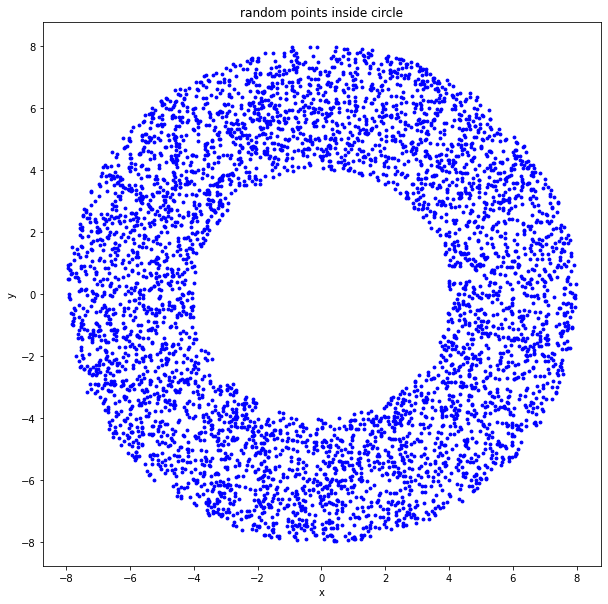

In [ ]:
def genRandPointsInRing(Rin=0,Rout=5,C=[0,0],n=1000):
    #first define parameters required for parametric equations
    if(Rout<Rin and Rin<0): return
    rho1 = np.sqrt(np.random.uniform(Rin**2, Rout**2,n))
    phi = np.random.uniform(0, 2*np.pi,n)

    x = C[0] + rho1 * np.cos(phi) 
    y = C[1] + rho1 * np.sin(phi)

    #Generated Set as required in Question
    Se = np.column_stack([x,y])
    return Se
Se = genRandPointsInRing(4,8,[0,0],5000)
plt.figure(figsize=(10,10))    
plt.scatter(Se[:,0],Se[:,1],s=8,color='b')
plt.title("random points inside circle")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [ ]:
def ChebyshevROC(R,d,npos,nneg):
    pos_mean = np.mean(npos,axis=0)
    neg_mean = np.mean(nneg,axis=0)
    pos_var = np.var(npos,axis=0)
    neg_var = np.var(nneg,axis=0)

    x1 = np.zeros(len(npos))
    Z1 = np.column_stack((npos,x1))

    x2 = np.ones(len(nneg))
    Z2 = np.column_stack((nneg,x2))

    DF = np.concatenate((Z1,Z2),axis = 0)

    lamda = np.arange(R[0], R[1], 0.05).tolist()
    TPR = []
    FPR = []

    for l in lamda:
        TP = 0
        TN = 0
        FP = 0
        FN = 0
        for p in DF:
            if((((p[0]-pos_mean[0])**2)<=l**2*pos_var[0]) and (((p[1]-pos_mean[1])**2)<=l**2*pos_var[1])):
                if(p[2]==0): TP += 1
                else :  FP += 1
            else:
                if(p[2]==1): TN += 1
                else: FN += 1
        tpr = TP/(TP+FN)
        fpr = FP/(TN+FP)
        TPR.append(tpr)
        FPR.append(fpr) 
    return TPR,FPR

def class_data_plot(pr1=0,pr2=5,nr1=4,nr2=8,PC=[0,0],NC=[0,0],pp=250,np=350):
    npos = genRandPointsInRing(pr1,pr2,PC,pp)
    nneg = genRandPointsInRing(nr1,nr2,NC,np)

    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(16,8))
    ax1.scatter(nneg[:,0],nneg[:,1],s=8,color='b')
    ax1.scatter(npos[:,0],npos[:,1],s=8,color='r')

    
    TPR,FPR = ChebyshevROC([0.01,10],0.05,npos,nneg)
    ax2.plot(FPR,TPR,color='g',linewidth=3)

    return TPR,FPR

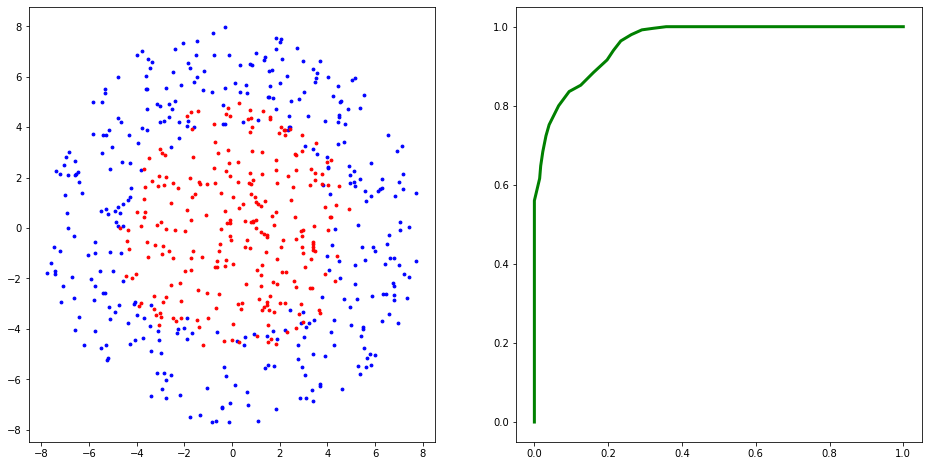

In [ ]:
tpr1,fpr1 = class_data_plot(0,5,4,8,[0,0],[0,0],250,350)

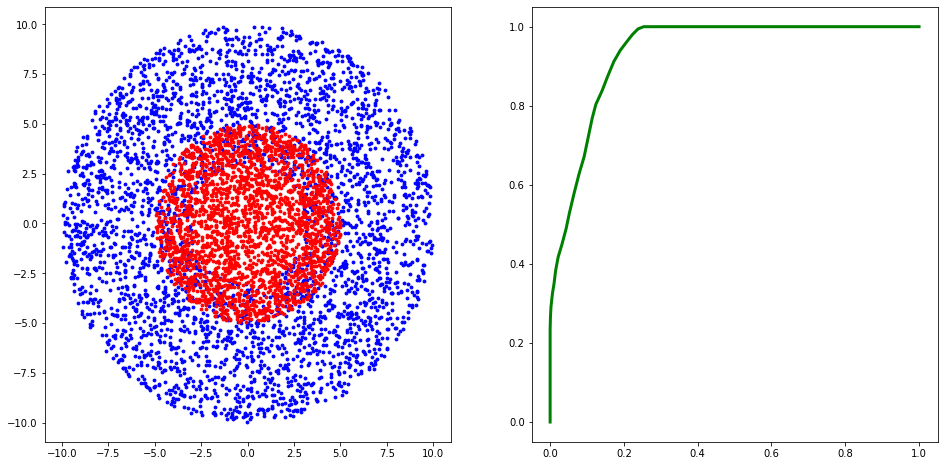

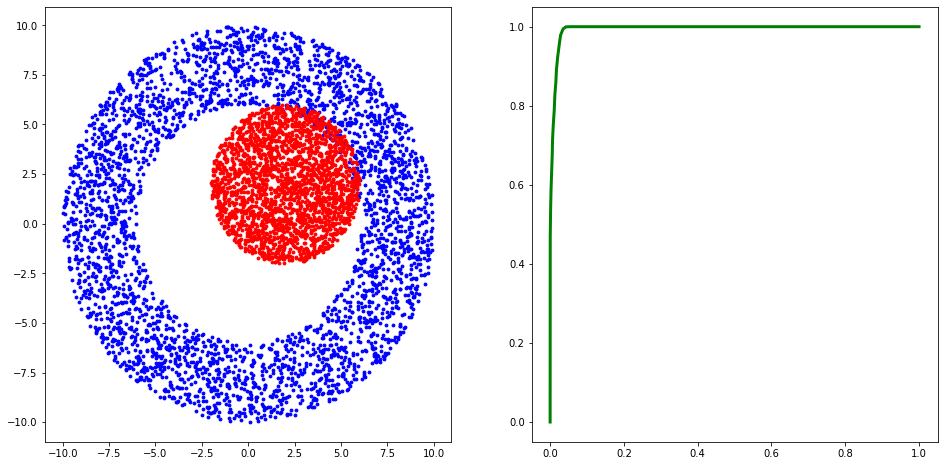

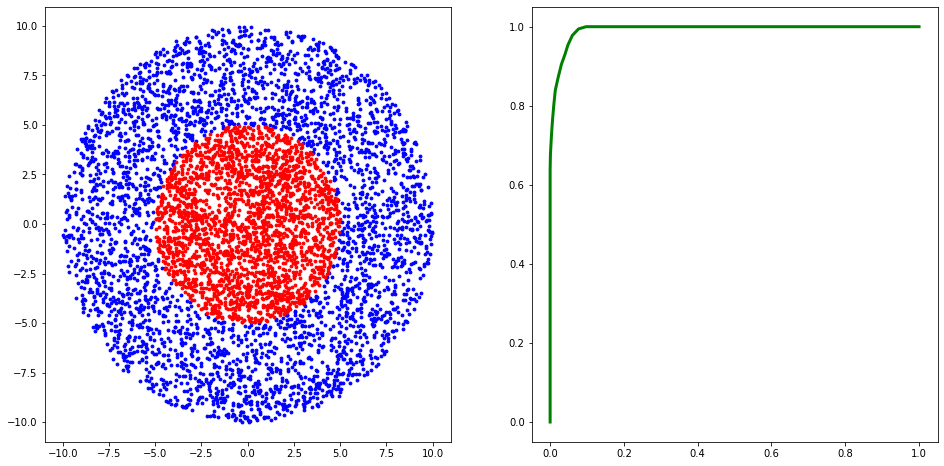

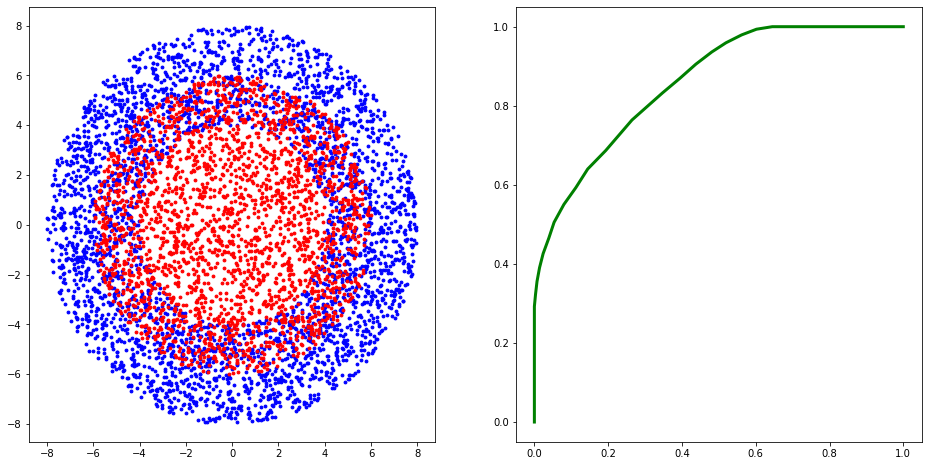

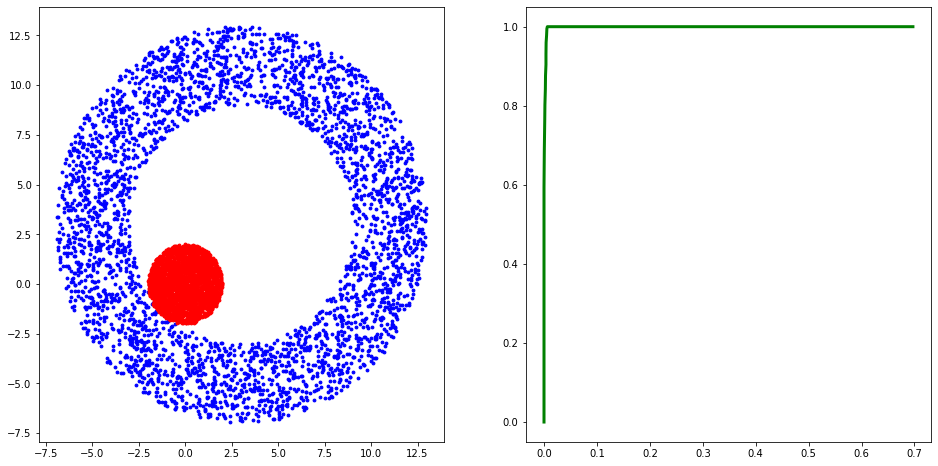

In [ ]:
tpr1,fpr1 = class_data_plot(0,5,3,10,[0,0],[0,0],2500,3500)
tpr2,fpr2 = class_data_plot(0,4,6,10,[2,2],[0,0],2500,3500)
tpr3,fpr3 = class_data_plot(0,5,5,10,[0,0],[0,0],2500,3500)
tpr4,fpr4 = class_data_plot(0,6,4,8,[0,0],[0,0],2500,3500)
tpr5,fpr5 = class_data_plot(0,2,6,10,[0,0],[3,3],2500,3500)

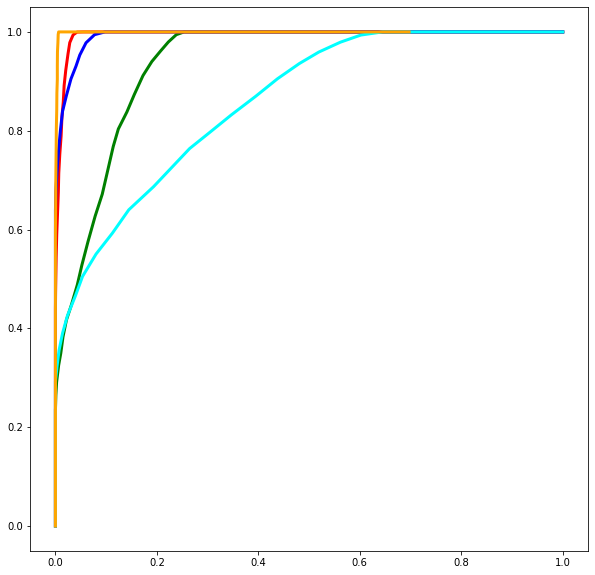

In [ ]:
plt.figure(figsize=(10,10))    
plt.plot(fpr1,tpr1,color='g',linewidth=3)
plt.plot(fpr2,tpr2,color='r',linewidth=3)
plt.plot(fpr3,tpr3,color='b',linewidth=3)
plt.plot(fpr4,tpr4,color='cyan',linewidth=3)
plt.plot(fpr5,tpr5,color='orange',linewidth=3)

# Q2. Incremental Clustering

In [ ]:
def generatePointFromRandomCluster():
    #make a matrix of (centerX, centerY, Radius)
    OG_clusters = np.array([[0,0,10], [0,50,15], [50,0,15], [0,-50,15], [-50,0,15], [35,35,15], [35,-35,15], [-35,35,15], [-35,-35,15], [0,100,20], [100,0,20], [0,-100,20], [-100,0,20], [70,70,20], [70,-70,20], [-70,70,20], [-70,-70,20]])
    N = 17
    
    #randomly choose one off 17 clusters
    chosen_cluster = np.random.randint(0,N)
    [centerX, centerY, Radius] = OG_clusters[chosen_cluster,:]
    
    #generate a random point inside circle
    theta = np.random.uniform(0, 2*np.pi)
    r = np.random.uniform(0,Radius)
    datapoint = np.array([r*np.cos(theta) + centerX, r*np.sin(theta) + centerY])
    return datapoint.reshape(-1,1)

generatePointFromRandomCluster().shape

(2, 1)

In [ ]:
def plot_my_ellipses(G):
    #define matrix that stores major & minor axes and rotation angle for each clusters
    #el_params - [major axes length, minor axes length, theta]
    el_params = np.zeros((G.shape[0],3))
    for i in range(G.shape[0]):
        #get the cov matrix for that cluster
        C = G[i,1]
        eigenvalues, eigenvectors = np.linalg.eig(C)
        
        #find larger eigenvalue - l1
        l1 = np.max(eigenvalues)
        #l2 is other eigenvalue
        l2 = np.min(eigenvalues)
        
        #v1 - principal eigenvector (corresponding to l1)
        v1 = eigenvectors[np.argmax(eigenvalues),:]
        #v2 - other eigenvector (corresponding to l2)
        v2 = eigenvectors[np.argmin(eigenvalues),:]
        
        el_params[i,0] = 2*np.sqrt(l1)
        el_params[i,1] = 2*np.sqrt(l2)
        el_params[i,2] = math.degrees(np.arctan(v1[1]/v1[0]))
        
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    ells = [Ellipse(xy=G[i,0], width=2*el_params[i,0], height=2*el_params[i,1], angle=el_params[i,2]) for i in range(G.shape[0])]

    for e in ells:
        ax.add_artist(e)
        e.set_clip_box(ax.bbox)
        #e.set_alpha(np.random.rand())
        e.set_facecolor(np.random.rand(3))

    ax.set_xlim(-120,120)
    ax.set_ylim(-120,120)

    plt.show()

In [ ]:
def incrementalClustering(maxIter=2000, vd=10, lmbda=3, K=50, alpha=0.001, t_thres=7000):
    
    #get first datapoint
    x = generatePointFromRandomCluster()
    
    #dimension of x
    n = x.shape[0]
    
    #matrix that will store cluster info - G [mean vector, covar matrix, prior scalar] for each dimension
    G = np.array([x,np.array([[vd,0],[0,vd]]),1.0],dtype=object).reshape(1,-1)
    
    #set the value of total no of cluster currently made
    curr_K = G.shape[0]
    
    #set t - total number of points in all clusters
    t = 1
    
    #for maxIter time instants
    for itr in range(1,maxIter):
        
        t = t+1
        
        #set alpha_t
        alpha_t = (1/t) if t<=t_thres else alpha
        
        #get a new datapoint
        xt = generatePointFromRandomCluster()
        
        #check membership of xt with all existing clusters
        dist = np.array([np.matmul(np.matmul((xt-G[i,0]).T,np.linalg.pinv(G[i,1])), xt-G[i,0]) for i in range(G.shape[0])])
        J = [dist<=(lmbda**2)]
        if np.sum(J)!=0:
            r = np.argmin(dist)
            #update prior of all G[i]
            for i in range(G.shape[0]):
                G[i,2] = (1-alpha_t)*G[i,2] if i!=r else ((1-alpha_t)*G[i,2] + alpha_t)
            #update cov of G[r]
            try:
                beta = alpha_t/G[r,2]
            except:
                print(G[r,:])
                print(r,t)
                print(G.shape)
            G[r,1] = (1 - beta)*(G[r,1] + beta*np.matmul(xt-G[r,0],(xt-G[r,0]).T))
            #update mean of G[r]
            G[r,0] = ((1 - beta)*G[r,0]) + (beta*xt)
            
        elif curr_K < K:
            #prior of G_new should be 1/t (i.e.alpha_t),
            #initialize it with 0, it will get updated when we update priors of all G[i]
            G_new = np.array([xt,np.array([[vd,0],[0,vd]]),0],dtype=object).reshape(1,-1)
            G = np.append(G,G_new, axis=0)
            
            curr_K = G.shape[0]
            
            #update prior of all G[i]
            for i in range(G.shape[0]):
                G[i,2] = (1-alpha_t)*G[i,2] if i!=(curr_K-1) else ((1-alpha_t)*G[i,2] + alpha_t)
            
        else:
            #delete the G with least prior
            idx = np.argmin(G[:,2])
            #get the number of points for the cluster to be deleted
            n_del = (t-1)*G[idx,2]
            #after deletion, the total no. of points in all cluster will be t-n_del-1
            #addition of new cluster brings the total to (t-n_del)
            #this changes the prior values as prior are generally (no of pts in a cluster)/(total no of points)
            G[idx,:] = np.array([xt,np.array([[vd,0],[0,vd]]),alpha_t],dtype=object).reshape(1,-1)
            
            #update prior of all G[i]
            for i in range(G.shape[0]):
                G[i,2] = ((t-1)*G[i,2])/(t-n_del)
            
            #update t
            t = t-n_del
        
    
        #plot after every 100 iterations
        if itr%100 == 0:
            plot_my_ellipses(G)
    return G

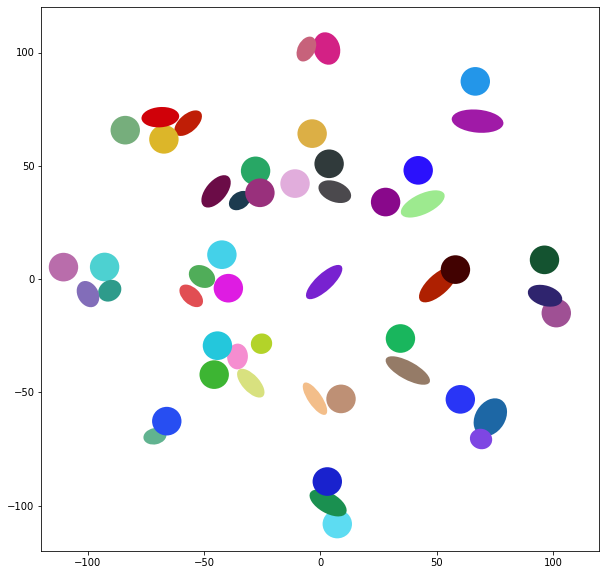

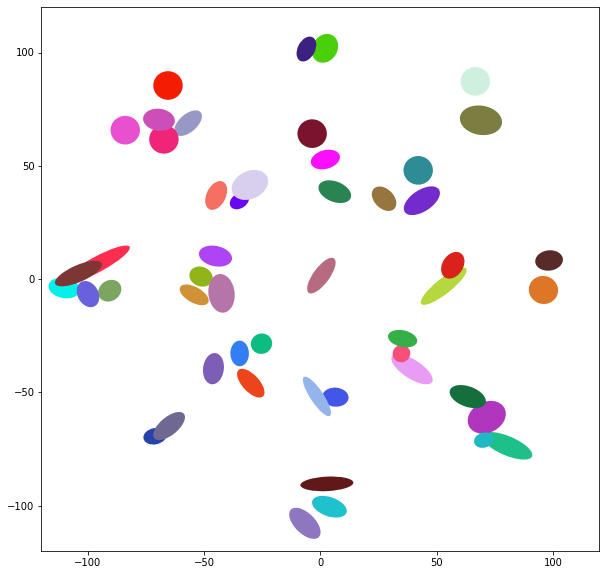

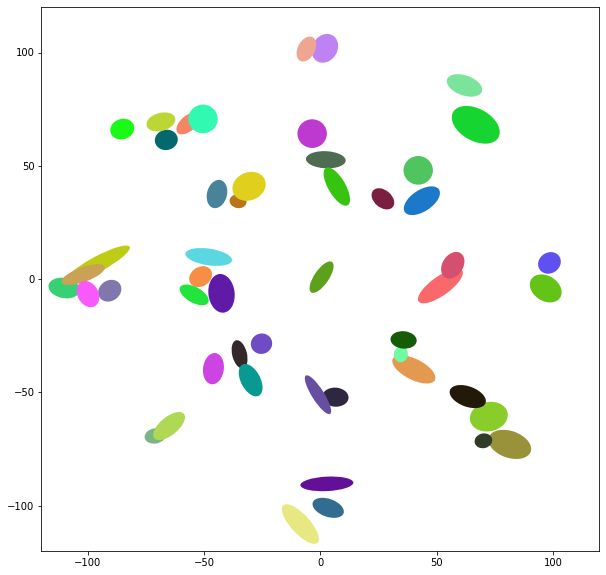

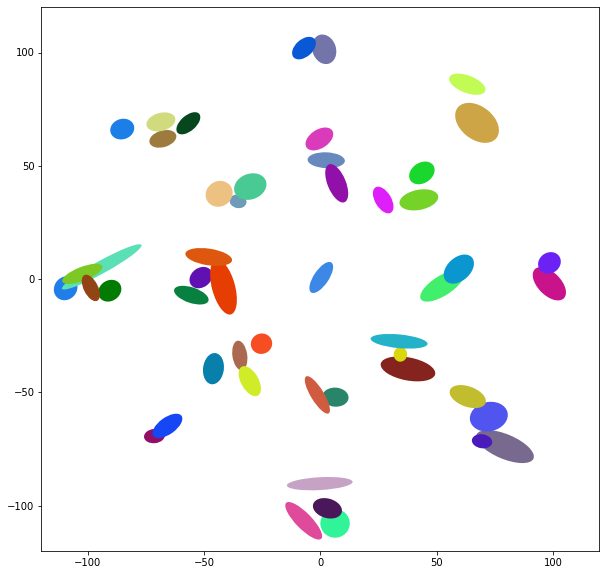

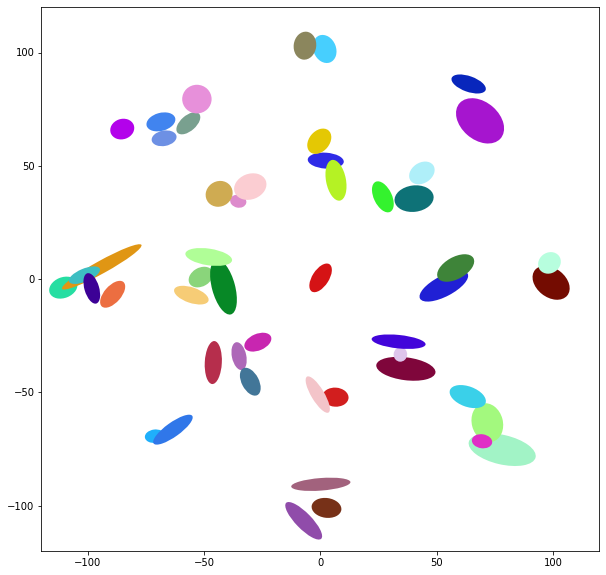

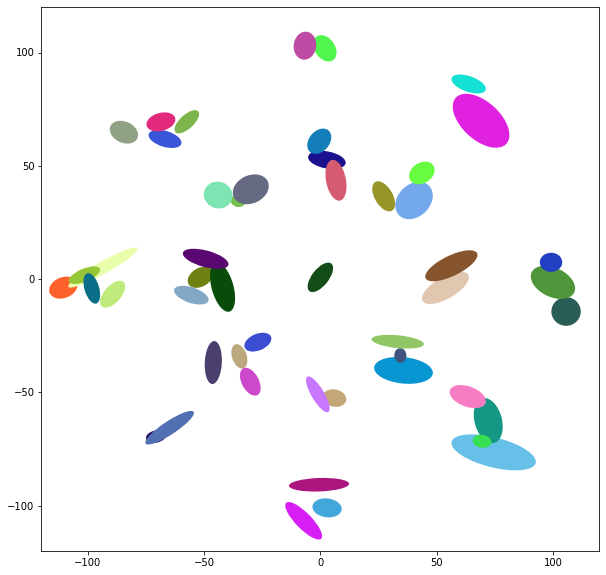

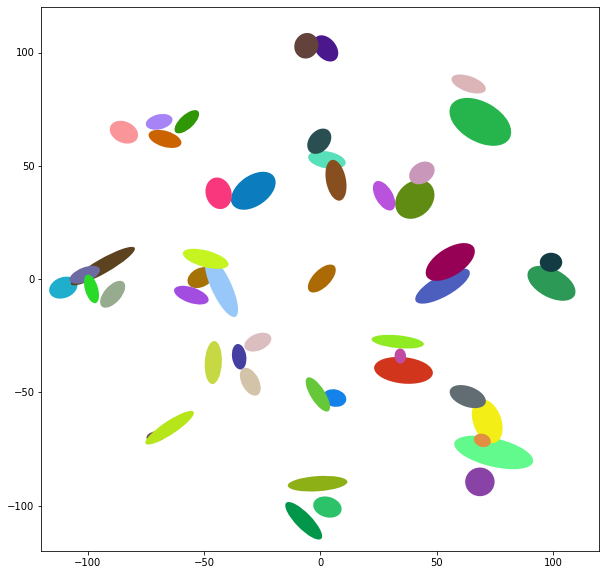

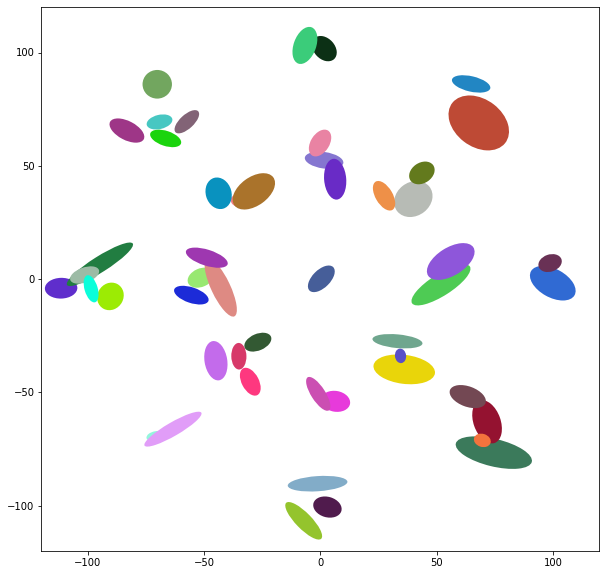

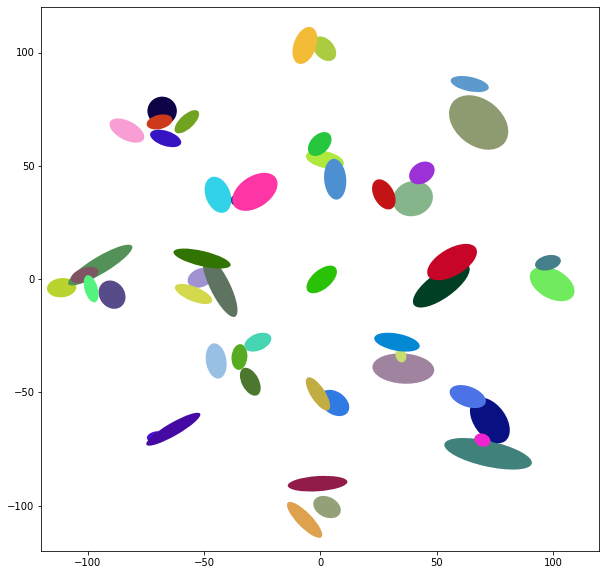

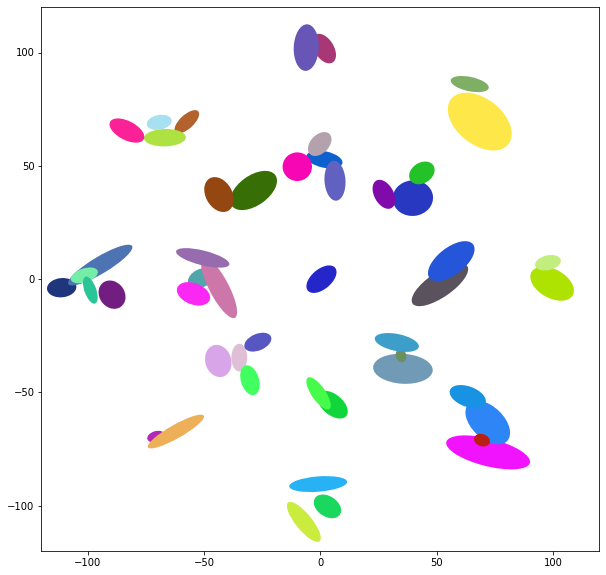

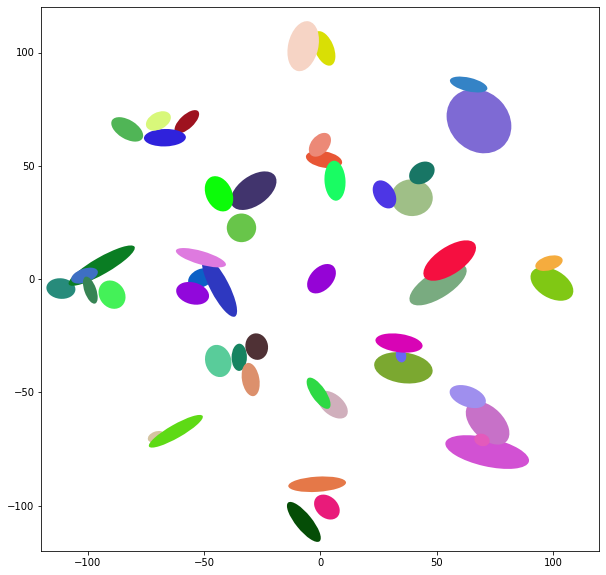

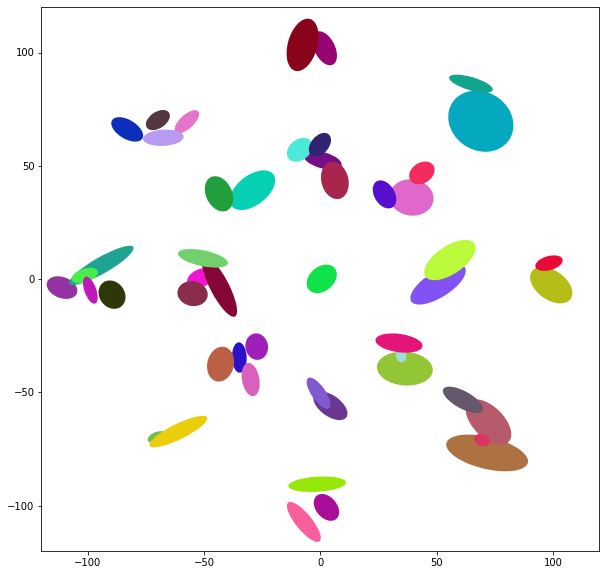

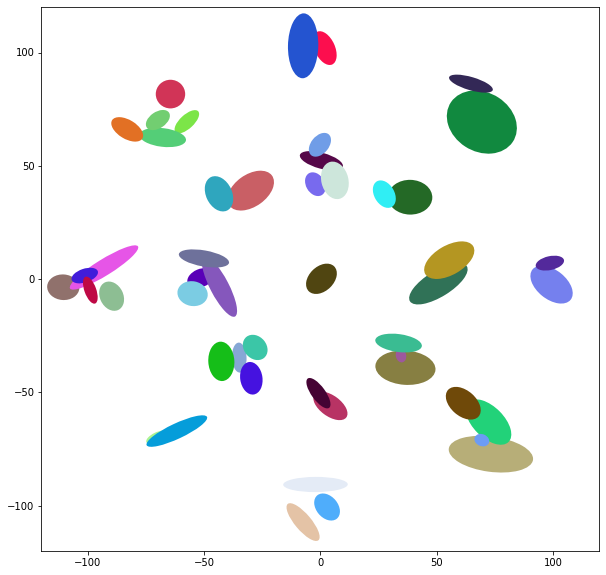

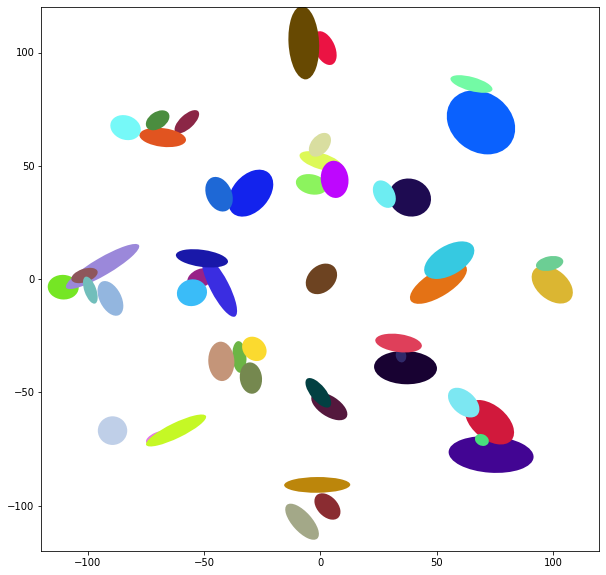

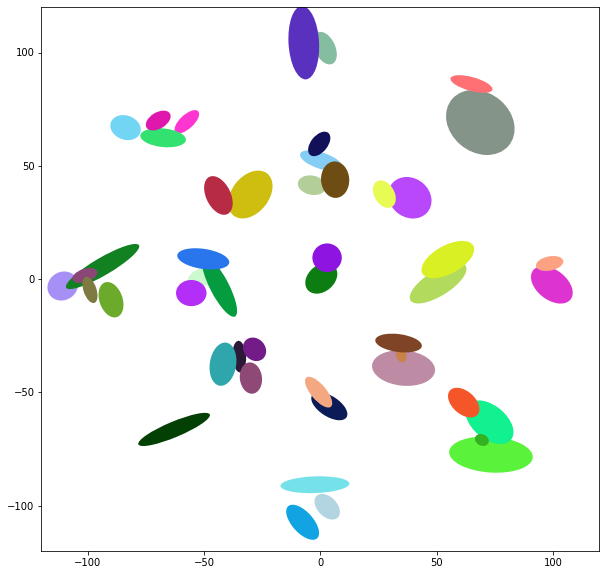

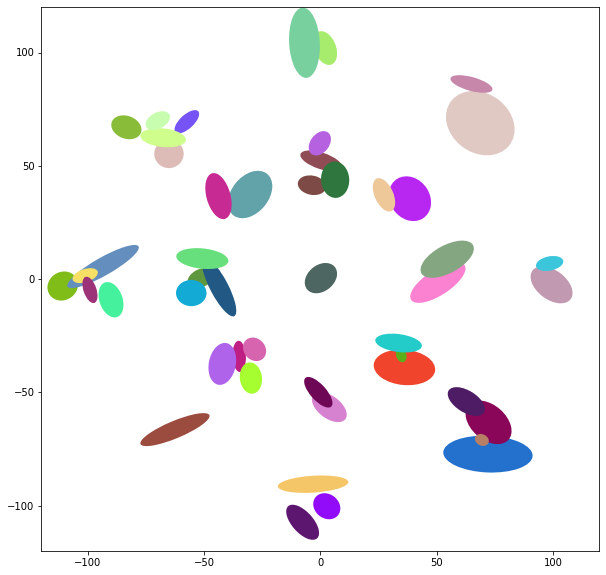

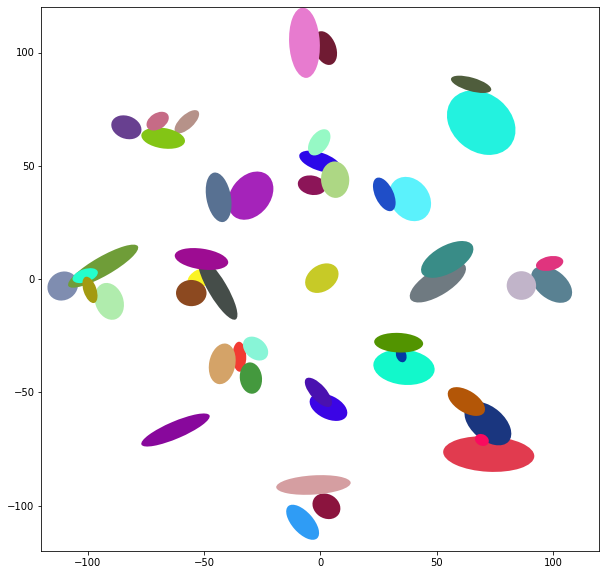

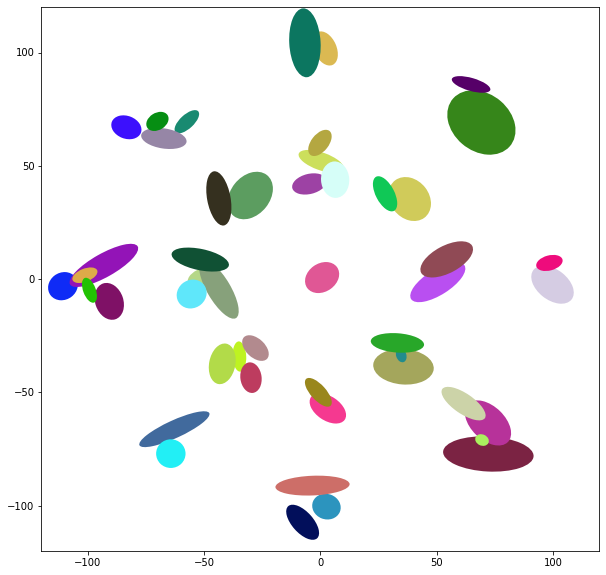

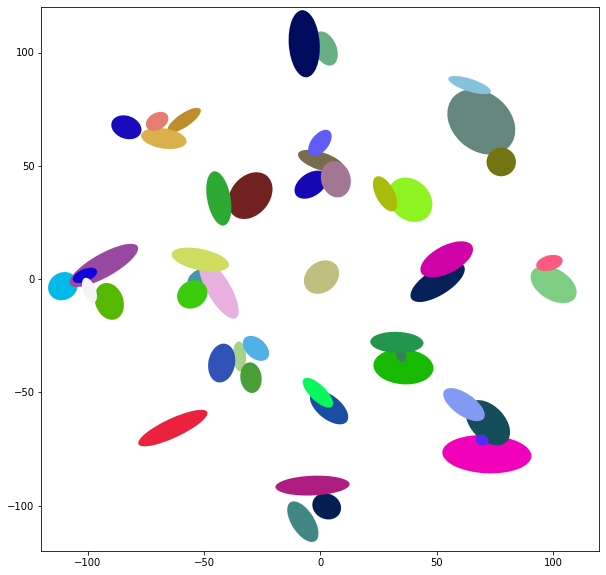

In [ ]:
G = incrementalClustering()

In [ ]:
np.sum(G[:,2])

0.9994313775652891

# Q3.

### Load Dataset

In [ ]:
mnist_data = fetch_openml('mnist_784', version=1)
print(mnist_data.keys())
X, Y = mnist_data['data'].to_numpy(), mnist_data['target'].to_numpy().astype(int)
print(X.shape)
print('Shape of X:', X.shape, '\n', 'Shape of y:', Y.shape)
unique, counts = np.unique(Y, return_counts=True)
print(np.asarray((unique, counts)).T)

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])
(70000, 784)
Shape of X: (70000, 784) 
 Shape of y: (70000,)
[[   0 6903]
 [   1 7877]
 [   2 6990]
 [   3 7141]
 [   4 6824]
 [   5 6313]
 [   6 6876]
 [   7 7293]
 [   8 6825]
 [   9 6958]]


### Train Test Split

In [ ]:
xt=[]
yt=[]
for i in range(10):
    tempx = X[Y==i]
    if i==0: 
        yt.append(np.zeros(len(tempx)))
    else:
        yt.append(np.ones(len(tempx))*i)
    xt.append(tempx)

X_tra = []
X_te = []
Y_tra = []
Y_te = []
for i in range(10):
    X_tra.append(xt[i][0:5000,:])
    X_te.append(xt[i][5000:6000,:])
    Y_tra.append(yt[i][0:5000])
    Y_te.append(yt[i][5000:6000])
X_tra = np.array(X_tra)
X_te = np.array(X_te)
Y_tra = np.array(Y_tra)
Y_te = np.array(Y_te)

X_train = X_tra.reshape(-1,784)
X_test = X_te.reshape(-1,784)

### PCA on Train

In [ ]:
def imageExtractionPCA(X,m=50000, d=500):
    #PCA
    mu = np.mean(X,axis=0)
    z = X-mu.T
    C = np.cov(z.T)
    eigenvalue, eigenvector = np.linalg.eig(C)
    idx = eigenvalue.argsort()[::-1]   
    eigenvalue = eigenvalue[idx]
    eigenvector = eigenvector[:,idx]
    Q = eigenvector[:,0:d]
    #Dimensionality Reduction Transform
    v = np.matmul(z,Q)
    return Q,v,mu

Q,X_train,mu = imageExtractionPCA(X_train,m=50000, d=230)

In [ ]:
X_train.shape

(50000, 230)

In [ ]:
X_train = X_train.reshape(10,5000,230)

In [ ]:
X_test = np.matmul(X_test-mu.T,Q)

In [ ]:
X_test = X_test.reshape(10,1000,230)

In [ ]:
X_test.shape

(10, 1000, 230)

### GMM for different k(mode) values

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture as mix
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
def GMM_k(k):
    ACC = []
    F1SC = []
    model_arr = np.array([mix(n_components = k, max_iter = 200,covariance_type='diag').fit(X_train[i]) for i in range(10)])
    PD = []
    for i in range(10):
        Pred = []
        for j in range(1000):
            x = X_test[i][j].reshape(1,-1)
            model_pred = []
            for k in range(10):
                model_pred.append(model_arr[k].score_samples(x))
            pr = np.array(model_pred).flatten()
            idx = pr.argsort()[::-1]
            Pred.append(idx[0])
        PD.append(Pred)
    PD = np.array(PD)
    tot = 0
    for i in range(10):
        temp = np.sum(Y_te[i]==PD[i])
        tot += temp
        t = temp/10
        ACC.append(t)
    tot = tot/10000
    Z = []
    for i in range(10):
        w = []
        for j in range(1000):
            if(PD[i][j]==i):
                w.append(1)
            else:
                w.append(0)
        Z.append(w)
    Z = np.array(Z)
    for i in range(10):
        t = f1_score(Z[i],np.ones(len(Z[i])))
        F1SC.append(t)
    return ACC,F1SC,tot
    

### Plotting Accuracy and F1-Score for different k

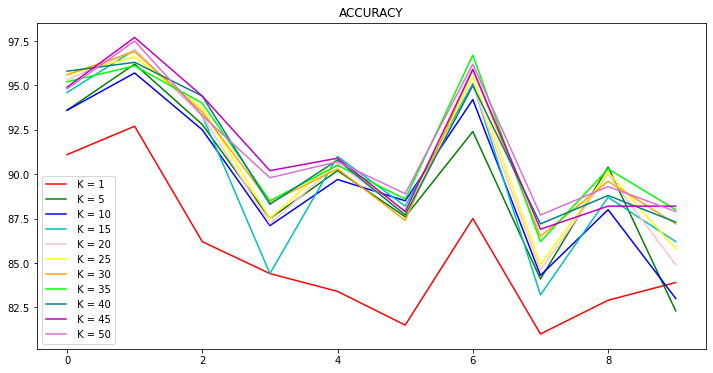

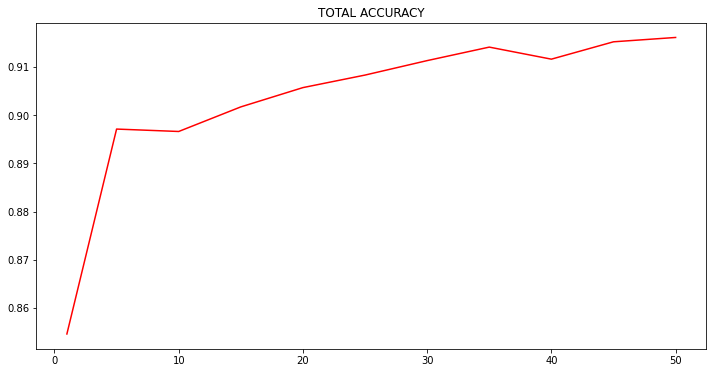

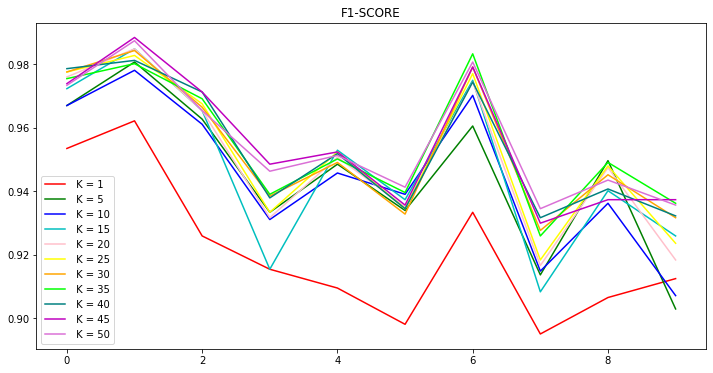

In [ ]:
def ACC_F1_PLOT():
    K = [1,5,10,15,20,25,30,35,40,45,50] 
    colors = ['r','g','b','c','pink','yellow','orange','lime','teal','m','orchid']
    AC = []
    F1 = []
    TOTACC = []
    for i in K:
        ACC,F1SC,tot = GMM_k(i)
        AC.append(ACC)
        F1.append(F1SC)
        TOTACC.append(tot)
    Xax = np.arange(0,10,1)
    
    plt.figure(figsize=(12,6))
    plt.title("ACCURACY")
    j = 0
    for i in K:
        s = " K = "+str(i)
        plt.plot(Xax,AC[j],color=colors[j],label=s)
        j += 1
    plt.legend(loc="best")
    plt.show()
    
    plt.figure(figsize=(12,6))
    plt.title("TOTAL ACCURACY")
    plt.plot(K,TOTACC,color='r')
    plt.show()
    
    plt.figure(figsize=(12,6))
    plt.title("F1-SCORE")
    j = 0
    for i in K:
        s = " K = "+str(i)
        plt.plot(Xax,F1[j],color=colors[j],label=s)
        j += 1
    plt.legend(loc="best")
    plt.show()
ACC_F1_PLOT()